In [78]:
import numpy as np
from pylab import *

%matplotlib notebook

In [1245]:
# trace is a list of (width, offset), one for each channel
nchan = 8
trace1 = [(0, np.array([1])) for w in range(nchan)]
trace2 = [(0, np.array([1])) for w in range(nchan//2)] + [(0, np.array([1,1])) for w in range(nchan//2)]
trace3 = [(1, np.array([1])) for w in range(nchan)]
trace4 = [(1, np.array([1])) for w in range(nchan//2)] + [(1, np.array([1,2,1])) for w in range(nchan//2)]
traces = [trace1, trace2, trace3, trace4]

In [1246]:
trace2

[(0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1, 1])),
 (0, array([1, 1])),
 (0, array([1, 1])),
 (0, array([1, 1]))]

In [1247]:
def trace2image(trace):
    '''
    Produces and image given a trace
    Trace is a list of (offset, kernel) tuples - length nchannels
    offset if positive for backwards in time.
    Offset for channel i is between channel i and channel i+1
    Kernel for channel 0 ends at time nt-1    
    '''
    nc = len(trace)
    kernels = [t[1] for t in trace]
    offsets = [t[0] for t in trace]
    last_off = offsets[-1]
    total_offset = sum(offsets)
    nt = len(kernels[-1]) + total_offset
    mask = np.zeros((nc,nt))
    coffset = nt # cumulative offset - right hand side of kernel
    for ichan, (offset, kernel) in enumerate(trace):
        
        endidx = coffset
        startidx = endidx - len(kernel)
        #print(ichan, offset, kernel, coffset, startidx, endidx)
        mask[ichan, startidx:endidx] = kernel
        coffset -= offset
        
        
    return mask

def image2trace(image):
    '''
    See vivek's idea for an imporvement
    '''
    nc = image.shape[0]
    trace = []
    curr_offset = 0
    for c in range(nc):
        x = image[c,:]
        kernel_idxs = np.where(x != 0)
        startidx = kernel_idxs[0]
        endidx = kernel_idxs[-1]
        krnl = x[startidx:endidx]
        trace.append((cuff_offset, krnl))
        curr_offset = old_start_idx - start_idx
        
        
        
    

In [1248]:
trace2image(trace3)

array([[0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.]])

<IPython.core.display.Javascript object>


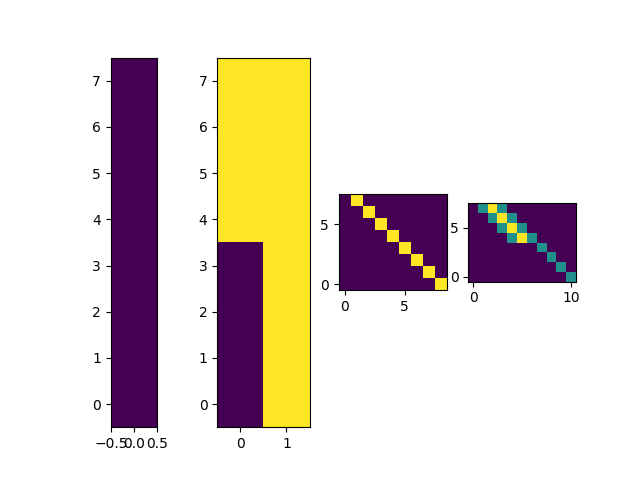

[(0, array([1])), (0, array([1])), (0, array([1])), (0, array([1])), (0, array([1])), (0, array([1])), (0, array([1])), (0, array([1]))] (8, 1)
[(0, array([1])), (0, array([1])), (0, array([1])), (0, array([1])), (0, array([1, 1])), (0, array([1, 1])), (0, array([1, 1])), (0, array([1, 1]))] (8, 2)
[(1, array([1])), (1, array([1])), (1, array([1])), (1, array([1])), (1, array([1])), (1, array([1])), (1, array([1])), (1, array([1]))] (8, 9)
[(1, array([1])), (1, array([1])), (1, array([1])), (1, array([1])), (1, array([1, 2, 1])), (1, array([1, 2, 1])), (1, array([1, 2, 1])), (1, array([1, 2, 1]))] (8, 11)


In [1249]:
fig, ax = subplots(1,len(traces))
for myax, t in zip(ax.flatten(), traces):
    img = trace2image(t)
    print(t, img.shape)
    myax.imshow(img, origin='lower')


In [1292]:
from collections import namedtuple
Product = namedtuple('Product', ['pid_upper','pid_lower','offset', 'desc'])

class EndProduct:
    def __init__(self, trace, desc):
        self.desc = desc
        self.offset, self.kernel = trace
        
    def __str__(self):
        s = f'EndProduct kernel={self.kernel}'
        return s
    
    def __eq__(self, other):
        '''
        Need this otherwise we keep adding the same kernel at the bottom level
        '''    
        iseq = np.array_equal(self.kernel, other.kernel)
        return iseq
    
    __repr__ = __str__

    

class EsamDescriptor:
    def __init__(self, nchan, ichan):
        self._products = [] # list containing Products
        self.nchan = nchan
        self.ichan = ichan
        assert self.nchan == 1 or self.nchan % 2 == 0
        
        if nchan == 1:
            self.upper = None
            self.lower = None
        else:
            # normally we'd do FdmtDescriptor here, butif we make a new __class_ if we have a subclass
            # then it'll create the right class
            self.upper = self.__class__(nchan // 2, 2*ichan+1)
            self.lower = self.__class__(nchan // 2, 2*ichan)
        
    @property
    def ndm(self):
        return len(self._products)
    
    @property
    def nprod(self):
        return self.ndm
    
    @property
    def total_products(self):
        '''
        Returns total number of products in hierarchy
        '''
        if self.nchan == 1:
            return self.nprod
        else:
            return self.upper.total_products + self.lower.total_products + self.nprod
        
    def descriptor_tree(self, tree=None, level=0):
        '''
        Returns a list. Each element contains another list. That list contains all descriptors for that iteration
        '''
        if tree is None:
            tree = []
        if self.ichan == 0:
            tree.append([])
            
        tree[level].append(self)
        if self.nchan != 1:
            self.lower.descriptor_tree(tree, level+1)
            self.upper.descriptor_tree(tree, level+1)
        
        return tree              
    
    def get_all_pids(self, all_pids):
        list_idx = int(np.log2(self.nchan))
        if self.nchan == 1:
            all_pids[list_idx].extend(self._products)
        else:
            all_pids[list_idx].extend(self._products)
            self.upper.get_all_pids(all_pids)
            self.lower.get_all_pids(all_pids)
    
    def get_trace_pid(self, trace) -> int:
        '''
        Returns the product ID for the given trace
        trace:list of nchan values. Each value is tuple(width, offset)'
        '''
        assert len(trace) == self.nchan, f'Unexpedcted trace length in {self}. Was {len(trace)} expected {self.nchan}'
        
        n2 = self.nchan // 2
        if self.nchan == 1:
            prod = EndProduct(trace[0], self)
        else:
            pid_lower = self.lower.get_trace_pid(trace[:n2])
            pid_upper = self.upper.get_trace_pid(trace[n2:])
            assert n2 - 1 >= 0
            mid_offset, _ = trace[n2-1] # offset and width of the lower of the 2 middle channels
            assert type(mid_offset) == int, f'offset has wrong type {type(mid_offset)} {mid_offset}'
            prod = Product(pid_upper, pid_lower, mid_offset, self)
        
        added = False
        if prod not in self._products:
            self._products.append(prod)
            added = True
            
        pid = self._products.index(prod)
        print(f'{self} of trace {trace}={prod}=PID{pid} added?={added}')
        
        return pid
        
     
    def __str__(self):
        s = f'Nchan={self.nchan} chan={self.ichan} ndm={self.ndm}'
        return s
    
    def __call__(self, din):
        assert din.shape[0] == self.nchan
        nt = din.shape[1]
        dout = np.zeros((self.nprod, nt)) # NT here is a bit tricky
        
        if self.nchan == 1:
            assert din.shape[0] == 1, f'Expected 1 channel. Got {din.shape}'
            for iprod, prod in enumerate(self._products):
                kernel = prod.kernel
                dout[iprod, :] = np.convolve(din[0], kernel, mode='same')                
        else:
            nf2 = self.nchan // 2 
            lower = self.lower(din[:nf2,...])
            upper = self.upper(din[nf2:,...])
            for iprod, prod in enumerate(self._products):
                off = prod.offset
                if off > 0:
                    dout[iprod, :off] = upper[prod.pid_upper, :off]
                
                dout[iprod, off:] = lower[prod.pid_lower, 0:nt-off] \
                        + upper[prod.pid_upper, off:]
            
        return dout                        
    
    __repr__ = __str__
    
    
d = EsamDescriptor(nchan,0)
d

Nchan=8 chan=0 ndm=0

In [1263]:
[d.get_trace_pid(t) for t in traces]

Nchan=1 chan=0 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=True
Nchan=1 chan=1 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=True
Nchan=2 chan=0 ndm=1 of trace [(0, array([1])), (0, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=0 ndm=1)=PID0 added?=True
Nchan=1 chan=2 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=True
Nchan=1 chan=3 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=True
Nchan=2 chan=1 ndm=1 of trace [(0, array([1])), (0, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=1 ndm=1)=PID0 added?=True
Nchan=4 chan=0 ndm=1 of trace [(0, array([1])), (0, array([1])), (0, array([1])), (0, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=4 chan=0 ndm=1)=PID0 added?=True
Nchan=1 chan=4 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=True
Nchan=1 chan=5 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PI

[0, 1, 2, 3]

In [1265]:
d.total_products

38

In [1266]:
din = np.ones((d.nchan, 16))
din[:] = 0
din[:,8] = 1
dout = d(din)
print(dout.shape)
dout

(4, 16)


array([[0., 0., 0., 0., 0., 0., 0., 0., 8., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 8., 4., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 3., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 4., 7., 6., 2., 0., 0., 0., 0.]])

<IPython.core.display.Javascript object>


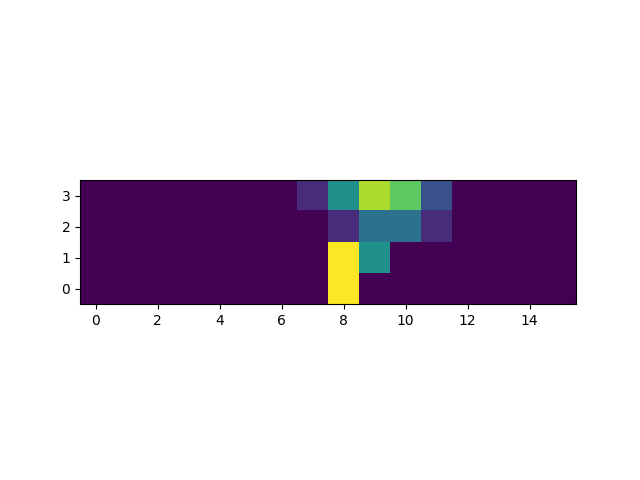

In [1267]:
figure()
imshow(dout, origin='lower')

In [1268]:
# unit tests
e1 = EndProduct((0,np.array([1,2,3])), None)
e2 = EndProduct((0,np.array([1,2,5])), None)
e3 = EndProduct((0,np.array([1])), None)

#e1 == e2
assert e1 in [e2,EndProduct((0,np.array([1,2,3])), None)] 
assert e3 not in [e1,e2] 
assert e3 not in [EndProduct((0, np.array([1,1])), None)]

In [1269]:
mtree = d.descriptor_tree()
print('tree depth', len(mtree))
for itree, t in enumerate(mtree):
    print('tree level', itree, 'nnodes=', len(t), t)

tree depth 4
tree level 0 nnodes= 1 [Nchan=8 chan=0 ndm=4]
tree level 1 nnodes= 2 [Nchan=4 chan=0 ndm=2, Nchan=4 chan=1 ndm=4]
tree level 2 nnodes= 4 [Nchan=2 chan=0 ndm=2, Nchan=2 chan=1 ndm=2, Nchan=2 chan=2 ndm=4, Nchan=2 chan=3 ndm=4]
tree level 3 nnodes= 8 [Nchan=1 chan=0 ndm=1, Nchan=1 chan=1 ndm=1, Nchan=1 chan=2 ndm=1, Nchan=1 chan=3 ndm=1, Nchan=1 chan=4 ndm=3, Nchan=1 chan=5 ndm=3, Nchan=1 chan=6 ndm=3, Nchan=1 chan=7 ndm=3]


In [1270]:
d.nchan

8

In [1271]:
d.lower.nchan

4

In [1272]:
d.lower.lower.nchan

2

In [1273]:
d.upper.upper.upper.ichan

7

In [1274]:
len(trace1)

8

In [1275]:
d.get_trace_pid(trace1)

Nchan=1 chan=0 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=1 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=2 chan=0 ndm=2 of trace [(0, array([1])), (0, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=0 ndm=2)=PID0 added?=False
Nchan=1 chan=2 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=3 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=2 chan=1 ndm=2 of trace [(0, array([1])), (0, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=1 ndm=2)=PID0 added?=False
Nchan=4 chan=0 ndm=2 of trace [(0, array([1])), (0, array([1])), (0, array([1])), (0, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=4 chan=0 ndm=2)=PID0 added?=False
Nchan=1 chan=4 ndm=3 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=5 ndm=3 of trace [(0, array([1]))]=EndProduct kerne

0

In [1276]:
d.get_trace_pid(trace1)

Nchan=1 chan=0 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=1 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=2 chan=0 ndm=2 of trace [(0, array([1])), (0, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=0 ndm=2)=PID0 added?=False
Nchan=1 chan=2 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=3 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=2 chan=1 ndm=2 of trace [(0, array([1])), (0, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=1 ndm=2)=PID0 added?=False
Nchan=4 chan=0 ndm=2 of trace [(0, array([1])), (0, array([1])), (0, array([1])), (0, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=4 chan=0 ndm=2)=PID0 added?=False
Nchan=1 chan=4 ndm=3 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=5 ndm=3 of trace [(0, array([1]))]=EndProduct kerne

0

In [1277]:
d._products

[Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=8 chan=0 ndm=4),
 Product(pid_upper=1, pid_lower=0, offset=0, desc=Nchan=8 chan=0 ndm=4),
 Product(pid_upper=2, pid_lower=1, offset=1, desc=Nchan=8 chan=0 ndm=4),
 Product(pid_upper=3, pid_lower=1, offset=1, desc=Nchan=8 chan=0 ndm=4)]

In [1278]:
d.total_products

38

In [1279]:
trace1

[(0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1]))]

In [1280]:
trace2

[(0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1, 1])),
 (0, array([1, 1])),
 (0, array([1, 1])),
 (0, array([1, 1]))]

In [1281]:
d.get_trace_pid(trace2)

Nchan=1 chan=0 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=1 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=2 chan=0 ndm=2 of trace [(0, array([1])), (0, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=0 ndm=2)=PID0 added?=False
Nchan=1 chan=2 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=3 ndm=1 of trace [(0, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=2 chan=1 ndm=2 of trace [(0, array([1])), (0, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=1 ndm=2)=PID0 added?=False
Nchan=4 chan=0 ndm=2 of trace [(0, array([1])), (0, array([1])), (0, array([1])), (0, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=4 chan=0 ndm=2)=PID0 added?=False
Nchan=1 chan=4 ndm=3 of trace [(0, array([1, 1]))]=EndProduct kernel=[1 1]=PID1 added?=False
Nchan=1 chan=5 ndm=3 of trace [(0, array([1, 1]))]=EndProdu

1

In [1282]:
d.total_products

38

In [1283]:
trace4

[(1, array([1])),
 (1, array([1])),
 (1, array([1])),
 (1, array([1])),
 (1, array([1, 2, 1])),
 (1, array([1, 2, 1])),
 (1, array([1, 2, 1])),
 (1, array([1, 2, 1]))]

In [1284]:
d.get_trace_pid(trace3)

Nchan=1 chan=0 ndm=1 of trace [(1, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=1 ndm=1 of trace [(1, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=2 chan=0 ndm=2 of trace [(1, array([1])), (1, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=0 ndm=2)=PID1 added?=False
Nchan=1 chan=2 ndm=1 of trace [(1, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=3 ndm=1 of trace [(1, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=2 chan=1 ndm=2 of trace [(1, array([1])), (1, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=1 ndm=2)=PID1 added?=False
Nchan=4 chan=0 ndm=2 of trace [(1, array([1])), (1, array([1])), (1, array([1])), (1, array([1]))]=Product(pid_upper=1, pid_lower=1, offset=1, desc=Nchan=4 chan=0 ndm=2)=PID1 added?=False
Nchan=1 chan=4 ndm=3 of trace [(1, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=5 ndm=3 of trace [(1, array([1]))]=EndProduct kerne

2

In [1285]:
d.get_trace_pid(trace4)

Nchan=1 chan=0 ndm=1 of trace [(1, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=1 ndm=1 of trace [(1, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=2 chan=0 ndm=2 of trace [(1, array([1])), (1, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=0 ndm=2)=PID1 added?=False
Nchan=1 chan=2 ndm=1 of trace [(1, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=1 chan=3 ndm=1 of trace [(1, array([1]))]=EndProduct kernel=[1]=PID0 added?=False
Nchan=2 chan=1 ndm=2 of trace [(1, array([1])), (1, array([1]))]=Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=1 ndm=2)=PID1 added?=False
Nchan=4 chan=0 ndm=2 of trace [(1, array([1])), (1, array([1])), (1, array([1])), (1, array([1]))]=Product(pid_upper=1, pid_lower=1, offset=1, desc=Nchan=4 chan=0 ndm=2)=PID1 added?=False
Nchan=1 chan=4 ndm=3 of trace [(1, array([1, 2, 1]))]=EndProduct kernel=[1 2 1]=PID2 added?=False
Nchan=1 chan=5 ndm=3 of trace [(1, array([1, 2, 1]))]=

3

In [1286]:
d._products

[Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=8 chan=0 ndm=4),
 Product(pid_upper=1, pid_lower=0, offset=0, desc=Nchan=8 chan=0 ndm=4),
 Product(pid_upper=2, pid_lower=1, offset=1, desc=Nchan=8 chan=0 ndm=4),
 Product(pid_upper=3, pid_lower=1, offset=1, desc=Nchan=8 chan=0 ndm=4)]

In [1287]:
d.total_products

38

In [1288]:
all_pids = [[] for i in range(int(np.log2(nchan))+1)]
d.get_all_pids(all_pids)
all_pids[1]

[Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=3 ndm=4),
 Product(pid_upper=1, pid_lower=1, offset=0, desc=Nchan=2 chan=3 ndm=4),
 Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=3 ndm=4),
 Product(pid_upper=2, pid_lower=2, offset=1, desc=Nchan=2 chan=3 ndm=4),
 Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=2 ndm=4),
 Product(pid_upper=1, pid_lower=1, offset=0, desc=Nchan=2 chan=2 ndm=4),
 Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=2 ndm=4),
 Product(pid_upper=2, pid_lower=2, offset=1, desc=Nchan=2 chan=2 ndm=4),
 Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=1 ndm=2),
 Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=1 ndm=2),
 Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=0 ndm=2),
 Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=0 ndm=2)]

In [1289]:
d.total_products

38

In [1290]:
d.descriptor_tree()

[[Nchan=8 chan=0 ndm=4],
 [Nchan=4 chan=0 ndm=2, Nchan=4 chan=1 ndm=4],
 [Nchan=2 chan=0 ndm=2,
  Nchan=2 chan=1 ndm=2,
  Nchan=2 chan=2 ndm=4,
  Nchan=2 chan=3 ndm=4],
 [Nchan=1 chan=0 ndm=1,
  Nchan=1 chan=1 ndm=1,
  Nchan=1 chan=2 ndm=1,
  Nchan=1 chan=3 ndm=1,
  Nchan=1 chan=4 ndm=3,
  Nchan=1 chan=5 ndm=3,
  Nchan=1 chan=6 ndm=3,
  Nchan=1 chan=7 ndm=3]]

In [1291]:
def fdmt_iteration(iterno, input_buffer, output_buffer, fdmt_tables):

    for output_channel_index in fdmt_tables.channels(iterno):
        for odm, id1, id2, offset, inchan1, inchan2 in fdmt_tables.dmlist(iterno, output_channel_index):
            output_buffer[odm, output_channel_index, :] = input_buffer[id1, inchan1, :] \
                                                        + input_buffer[id2, inchan2, offset:]
                
                
def fdmt_function(input_buffer, output_buffer, fdmt_tables):
    buffers = [np.zeros(fdmt_tables.output_buffer(i)) for i in range(fdmt_tables.niter)]
    
    buffers[0] = input_buffer # allocate the input
    
    for iterno in fdmt_tables:
        fdmt_iteration(iterno, buffers[i], buffers[i+1], fdmt_tables)
        
        
    return buffers[-1]



# ESAM - Efficient Summation of Arbirary Masks
This whole thing is completely general - we can have a full 1D convolution with arbitrary weights per channel and it remains general (in fact it's simpler to understand and code up)

